In [140]:
# for analysis and data processing
import pandas as pd
import numpy as np
import seaborn as sns
import ppscore as pps
import datetime as dt
import re
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing 
# for modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [166]:
def read_data(path_to_csv_file):
    '''
    Reads csv files from specified paths

    Parameters:
            path to csv file locations
    Returns:
            dataframes of imported csv files
    '''
    # Read CSV files
    df = pd.read_csv(path_to_csv_file)
    
    return df

# call the function to import train data - update with relevant paths
data = read_data('/Users/mncedisimncwabe/Downloads/input.csv')

In [3]:
def df_snapshot(df):
    '''
    Returns top 5 rows of the dataframe.

    Parameters:
        df (DataFrame): Pandas dataframe
    '''
    return display(df.head())

print(f'data:')
df_snapshot(data)

data:


,Street_Address,Date,Tip,Phone_Number,Gender,Type,Price,Payment_Type,Time_In,Time_Out,Age,Time_Elapsed,Miles,Date_Fixed,Time_In_Bucket
0,185 King,5/19/2016,3.00,NaN,M,W,17.76,C,01:17,NaN,NaN,NaN,1.012882,2016/05/19,Morning
1,15 Kracke St,6/7/2016,2.78,NaN,M,R,NaN,R,03:30,NaN,NaN,NaN,1.501924,2016/06//7,Morning
2,36 Legare Street,6/13/2016,2.62,7.292634e+06,F,R,12.38,C,10:39,11:52,O,73.0,1.240314,2016/06/13,Morning
3,109 Bee Street,05/31/16,2.00,NaN,M,W,16.02,C,10:48,11:40,NaN,52.0,1.775961,2016/05/31,Morning
4,125 Calhoun,6/15/2016,1.93,8.438058e+09,F,W,18.07,C,10:49,12:10,M,81.0,0.422552,2016/06/15,Morning


In [19]:
def data_types(df):
    '''
    Returns datatype of fields in a dataframe.

    Parameters:
        df (DataFrame): Pandas dataframe
    '''
    return df.info()

print(f'data:')
data_types(data)

data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 772 entries, 0 to 771
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Street_Address  772 non-null    object        
 1   Date            341 non-null    datetime64[ns]
 2   Tip             671 non-null    float64       
 3   Phone_Number    566 non-null    float64       
 4   Gender          663 non-null    object        
 5   Type            584 non-null    object        
 6   Price           568 non-null    float64       
 7   Payment_Type    624 non-null    object        
 8   Time_In         715 non-null    object        
 9   Time_Out        462 non-null    object        
 10  Age             481 non-null    object        
 11  Time_Elapsed    457 non-null    float64       
 12  Miles           772 non-null    float64       
 13  Date_Fixed      772 non-null    datetime64[ns]
 14  Time_In_Bucket  714 non-null    object        
dtype

## 1. Data Cleansing and Preprocessing

- As seen above some columns are not in thier correct data type and need to be converted.
Eg Date_Fixed is stored as an object and needs to be converted to datatime. 
- Some records in the date_fixed column have double slashes like 2016/04//01. So we need a function that handles these to make the data consistent and then convert the date ti datetime after.

In [167]:
def preprocess_date_string(date_str):
    """
    Fix common issues in date strings such as extra slashes.

    """
    # Remove any double slashes and replace with a single slash
    date_str = re.sub(r'//+', '/', date_str)
    
    return date_str

def convert_dates_to_datetime(df, column):
    """
    Returns a dataframe with converted dates field from object to datetime.
    
    """
    # Preprocess the date strings to fix common issues
    df[column] = df[column].apply(lambda x: preprocess_date_string(x) if pd.notnull(x) else x)
    
    # Convert the preprocessed date strings to datetime
    df[column] = pd.to_datetime(df[column], errors='coerce')
    
    return df

data = convert_dates_to_datetime(data, 'Date_Fixed')
data = convert_dates_to_datetime(data, 'Date')
data.head()

,Street_Address,Date,Tip,Phone_Number,Gender,Type,Price,Payment_Type,Time_In,Time_Out,Age,Time_Elapsed,Miles,Date_Fixed,Time_In_Bucket
0,185 King,2016-05-19,3.00,NaN,M,W,17.76,C,01:17,NaN,NaN,NaN,1.012882,2016-05-19,Morning
1,15 Kracke St,2016-06-07,2.78,NaN,M,R,NaN,R,03:30,NaN,NaN,NaN,1.501924,2016-06-07,Morning
2,36 Legare Street,2016-06-13,2.62,7.292634e+06,F,R,12.38,C,10:39,11:52,O,73.0,1.240314,2016-06-13,Morning
3,109 Bee Street,NaT,2.00,NaN,M,W,16.02,C,10:48,11:40,NaN,52.0,1.775961,2016-05-31,Morning
4,125 Calhoun,2016-06-15,1.93,8.438058e+09,F,W,18.07,C,10:49,12:10,M,81.0,0.422552,2016-06-15,Morning


- Now both date and date_fixed columns have been converted from objext/string to the correct date type. We do this becaue we'' do some feature engineering to extract some date components from the date field thatn can be usefull for model building such as if there's any correlation between day of the month and the time it takes to deliver an order.

- Now, let's Check for some nulls in the dataset and devise a strategy to handle them.

In [18]:
def null_checker(df):
    '''
    Returns the count of rows found in the data frame where there is a null present.

    Parameters:
        df (Dataframe): Pandas dataframe

    Returns:
        Prints the null count, null percentage, and row count per column.
    '''
    row_count = len(df)
    null_counts = df.isnull().sum().sort_values(ascending=False)
    null_percentages = (null_counts / row_count) * 100
    combined = pd.concat([null_counts, null_percentages], axis=1, keys=['Null Count', 'Null Percentage'])
    combined['Row Count'] = row_count
    print(combined)

print(f'data:')
null_checker(data)

data:
                Null Count  Null Percentage  Row Count
Date                   431        55.829016        772
Time_Elapsed           315        40.803109        772
Time_Out               310        40.155440        772
Age                    291        37.694301        772
Phone_Number           206        26.683938        772
Price                  204        26.424870        772
Type                   188        24.352332        772
Payment_Type           148        19.170984        772
Gender                 109        14.119171        772
Tip                    101        13.082902        772
Time_In_Bucket          58         7.512953        772
Time_In                 57         7.383420        772
Street_Address           0         0.000000        772
Miles                    0         0.000000        772
Date_Fixed               0         0.000000        772


#### Dropping some columns
- Majority of the columns have missing values, such as Date with more than 55% missing records but we can drop this fieled because we have Date_Fixed that we can use to extract date components from.
- We can also remove Time_In and Time_Out since Time_Elapsed is derived from these two, so it won't make sense to use these two to predict time elapsed.
- We will also drop the Phone Number, Street_Address as these won't necessarily give any contribution to predicting time elapsed.

In [168]:
def drop_unnecessary_columns(df, columns):
    """
    Drops unnecessary columns from the dataframe.

    """
    df = df.drop(columns, axis=1)
    return df

columns_to_drop = ['Street_Address','Date', 'Time_Out', 'Time_In', 'Phone_Number']
data = drop_unnecessary_columns(data, columns_to_drop)
data.head()


,Tip,Gender,Type,Price,Payment_Type,Age,Time_Elapsed,Miles,Date_Fixed,Time_In_Bucket
0,3.00,M,W,17.76,C,NaN,NaN,1.012882,2016-05-19,Morning
1,2.78,M,R,NaN,R,NaN,NaN,1.501924,2016-06-07,Morning
2,2.62,F,R,12.38,C,O,73.0,1.240314,2016-06-13,Morning
3,2.00,M,W,16.02,C,NaN,52.0,1.775961,2016-05-31,Morning
4,1.93,F,W,18.07,C,M,81.0,0.422552,2016-06-15,Morning


### Handle missing values
- Befoe we do missing value imputation let's do some distribution plots to see how each column is disstributed so we can choose a proper missing value imputation strategy.

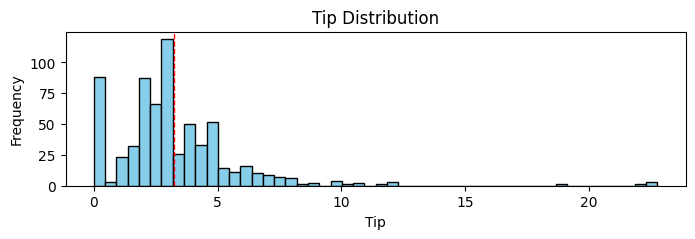

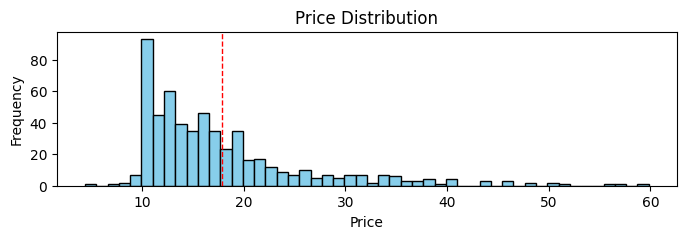

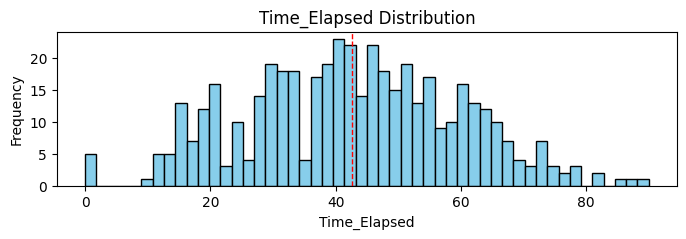

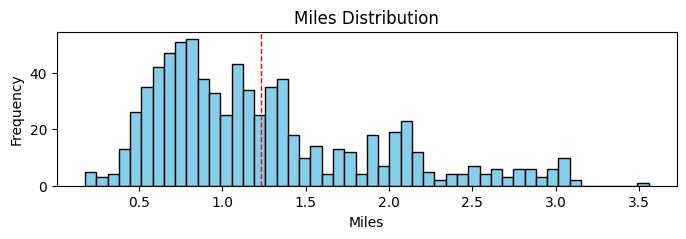

In [39]:
def plot_numerical_distributions(df, columns):
    """
    Plots the distributions of specified numerical columns in a DataFrame.
    
    """
    for column in columns:
        if column in df.columns:
            plt.figure(figsize=(8, 2))
            plt.hist(df[column].dropna(), bins=50, color='skyblue', edgecolor='black')
            plt.title(f'{column} Distribution')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.axvline(df[column].mean(), color='red', linestyle='dashed', linewidth=1)
            plt.show()
        else:
            print(f"Column '{column}' not found in DataFrame")

columns_to_plot = ['Tip', 'Price','Time_Elapsed','Miles']
plot_numerical_distributions(data, columns_to_plot)

### Insights
- Tip Distribution: The majority of the tips are clustered around lower values, with a significant peak around $5. The distribution is right-skewed with a long tail.
- Price Distribution: The prices are also right-skewed, with a majority of values concentrated between $10 and $20.
- Time_Elapsed Distribution: The distribution of the time elapsed is roughly normal with a peak around 40 minutes.
- Miles Distribution: Most deliveries occur within 0.5 to 1.5 miles, with a peak around 1 mile and a long right tail.

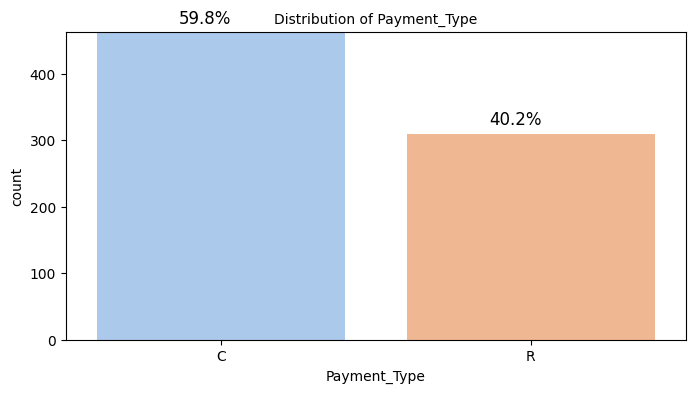

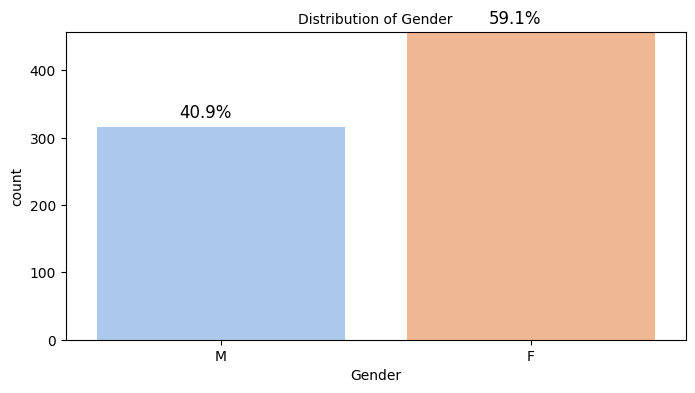

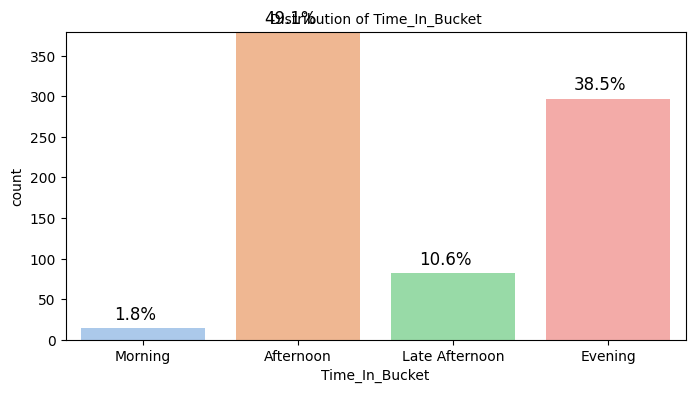

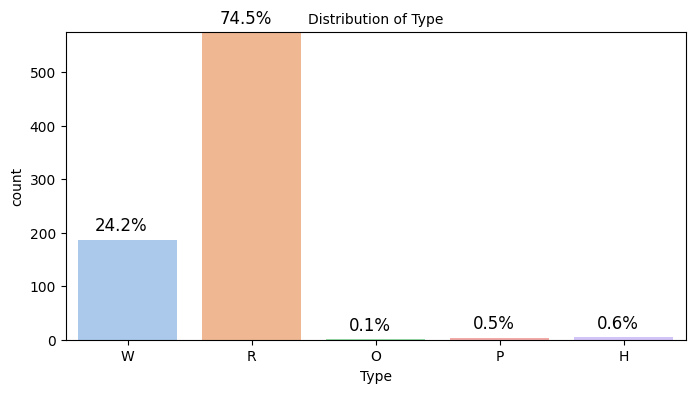

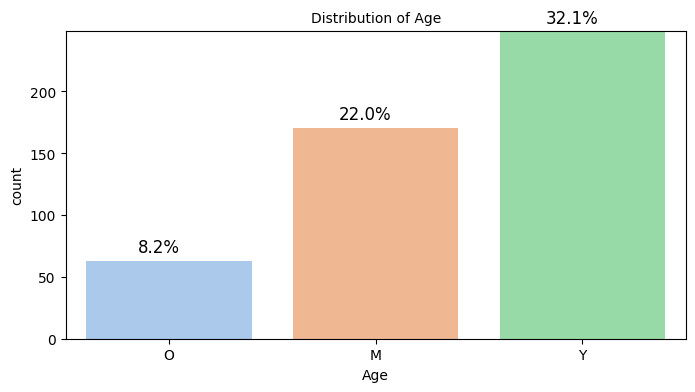

In [46]:
def plot_categorical_distributions(data, columns):
    """
    Plots the distributions of specified categorical columns.

    """
    for column in columns:
        plt.figure(figsize=(8, 4))
        plt.title(f"Distribution of {column}", fontsize=10)
        plot = sns.countplot(x=column, data=data, palette='pastel')
        plt.ylim(0, data[column].value_counts().max() + 1)
        
        total = len(data[column])
        for p in plot.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height() / total)
            x = p.get_x() + p.get_width() / 2 - 0.05
            y = p.get_y() + p.get_height()
            plot.annotate(percentage, (x, y), size=12, ha='center', va='center', xytext=(0, 10), textcoords='offset points')
        
        plt.show()

cat_vars = ['Payment_Type','Gender', 'Time_In_Bucket', 'Type','Age']
plot_categorical_distributions(data, cat_vars)

#### Insights

- Payment_Type Distribution: The payment types are almost equally distributed between cash ('C') and credit ('R'), with a slight edge for cash payments (40.7% for 'C' and 40.2% for 'R').
- Gender Distribution: The distribution of gender is fairly balanced, with a slightly higher proportion of females (44.9%) compared to males (40.9%).
- Time_In_Bucket Distribution: Most orders are placed in the afternoon (41.6%) and evening (38.5%). Morning and late afternoon have significantly fewer orders, with morning having the least (1.8%).
- Type Distribution: The majority of orders are from residences ('R') at 50.1%, followed by work locations ('W') at 24.2%. Other categories like 'O', 'P', and 'H' have very few orders.
- Age Distribution: The majority of customers placing orders Young ('Y) and Middle aged customers.

Given these distributions, using the median to impute missing values for numerical columns Tip, Price and Miles is a reasonable approach for several reasons:

- Skewness: For skewed distributions (like Tip and Price), the median is a better measure of central tendency than the mean because it is less affected by outliers.
- Normal Distribution: For approximately normal distributions (like Time_Elapsed), the median still provides a robust measure that is not overly influenced by any extreme values.
- We wiil drop all records where Time_Elapsed is missing since this is the feature we are predicting.

Using the mode (most frequent value) for imputing missing values in the categorical columns Type, Payment_Type, Gender and Time_In_Bucket is a suitable approach. The mode represents the most common category, making it a logical choice for imputation.

In [169]:
def impute_missing_values_with_median(df, columns):
    """
    Imputes missing values in specified numerical columns with the median.

    """
    for column in columns:
        median_value = df[column].median()
        df[column].fillna(median_value, inplace=True)
    
    return df

columns_to_impute = ['Tip', 'Price', 'Miles']
data = impute_missing_values_with_median(data, columns_to_impute)

In [170]:
def impute_missing_values_with_mode(df, columns):
    """
    Imputes missing values in specified categorical columns with the mode.
    
    """
    for column in columns:
        mode_value = df[column].mode()[0]
        df[column].fillna(mode_value, inplace=True)
    
    return df

categorical_columns_to_impute = ['Payment_Type', 'Gender', 'Time_In_Bucket', 'Type','Age']
data = impute_missing_values_with_mode(data, categorical_columns_to_impute)

In [49]:
data.head()

,Tip,Gender,Type,Price,Payment_Type,Age,Time_Elapsed,Miles,Date_Fixed,Time_In_Bucket
0,3.00,M,W,17.76,C,Y,NaN,1.012882,2016-05-19,Morning
1,2.78,M,R,15.58,R,Y,NaN,1.501924,2016-06-07,Morning
2,2.62,F,R,12.38,C,O,73.0,1.240314,2016-06-13,Morning
3,2.00,M,W,16.02,C,Y,52.0,1.775961,2016-05-31,Morning
4,1.93,F,W,18.07,C,M,81.0,0.422552,2016-06-15,Morning


#### Feature engineering

- Now we extract date parts from date_fixed column so we can analyse if there's any relationship between these and time_elapsed.
- We will also create an additional feature is_weekend to distinguish betwen weekends or weekdays orders.
- We will also create interacting terms Price_per_Mile and Tip_per_Mile as these may enhance model performance.

In [171]:
def extract_date_parts_and_drop(df, column):
    """
    Extracts day of the week, day of the month, and month from a date column, adds them as new columns,
    and drops the original date column.
    """
    df[column] = pd.to_datetime(df[column], errors='coerce')
    
    # Extract day of the week, day of the month, and month
    df['Day_of_Week'] = df[column].dt.day_name()
    df['Day_of_Month'] = df[column].dt.day
    df['Month'] = df[column].dt.month_name()
    df['Week_of_Year'] = df[column].dt.isocalendar().week
    df['Is_Weekend'] = (df[column].dt.weekday >= 5).astype(int)
    
    # Drop the original date column
    df = df.drop(columns=[column])
    
    return df
data = extract_date_parts_and_drop(data, 'Date_Fixed')
data.head()

,Tip,Gender,Type,Price,Payment_Type,Age,Time_Elapsed,Miles,Time_In_Bucket,Day_of_Week,Day_of_Month,Month,Week_of_Year,Is_Weekend
0,3.00,M,W,17.76,C,Y,NaN,1.012882,Morning,Thursday,19,May,20,0
1,2.78,M,R,15.58,R,Y,NaN,1.501924,Morning,Tuesday,7,June,23,0
2,2.62,F,R,12.38,C,O,73.0,1.240314,Morning,Monday,13,June,24,0
3,2.00,M,W,16.02,C,Y,52.0,1.775961,Morning,Tuesday,31,May,22,0
4,1.93,F,W,18.07,C,M,81.0,0.422552,Morning,Wednesday,15,June,24,0


In [172]:
def create_interaction_features(df):
    """
    Creates interaction features in the DataFrame.
    
    Parameters:
        df (DataFrame): Pandas dataframe
    
    Returns:
        DataFrame: Pandas dataframe with new interaction features
    """
    df['Price_per_Mile'] = df['Price'] / df['Miles']
    df['Tip_per_Mile'] = df['Tip'] / df['Miles']
    
    return df
data = create_interaction_features(data)
data.head()

,Tip,Gender,Type,Price,Payment_Type,Age,Time_Elapsed,Miles,Time_In_Bucket,Day_of_Week,Day_of_Month,Month,Week_of_Year,Is_Weekend,Price_per_Mile,Tip_per_Mile
0,3.00,M,W,17.76,C,Y,NaN,1.012882,Morning,Thursday,19,May,20,0,17.534125,2.961846
1,2.78,M,R,15.58,R,Y,NaN,1.501924,Morning,Tuesday,7,June,23,0,10.373362,1.850959
2,2.62,F,R,12.38,C,O,73.0,1.240314,Morning,Monday,13,June,24,0,9.981340,2.112368
3,2.00,M,W,16.02,C,Y,52.0,1.775961,Morning,Tuesday,31,May,22,0,9.020467,1.126151
4,1.93,F,W,18.07,C,M,81.0,0.422552,Morning,Wednesday,15,June,24,0,42.763968,4.567485


In [173]:
# drop records with missing Time_Elapsed
def drop_nulls_from_column(df, column):
    """
    Drops records from the DataFrame where the specified column contains null values.
    
    """
    df = df.dropna(subset=[column])
    return df

data = drop_nulls_from_column(data, 'Time_Elapsed')
data.head()

,Tip,Gender,Type,Price,Payment_Type,Age,Time_Elapsed,Miles,Time_In_Bucket,Day_of_Week,Day_of_Month,Month,Week_of_Year,Is_Weekend,Price_per_Mile,Tip_per_Mile
2,2.62,F,R,12.38,C,O,73.0,1.240314,Morning,Monday,13,June,24,0,9.981340,2.112368
3,2.00,M,W,16.02,C,Y,52.0,1.775961,Morning,Tuesday,31,May,22,0,9.020467,1.126151
4,1.93,F,W,18.07,C,M,81.0,0.422552,Morning,Wednesday,15,June,24,0,42.763968,4.567485
5,3.75,F,W,37.25,R,M,75.0,1.061973,Morning,Wednesday,15,June,24,0,35.076235,3.531165
6,2.30,M,W,29.72,C,Y,42.0,0.733873,Morning,Monday,13,June,24,0,40.497448,3.134056


- After dropping nulls from Time_Elapsed the records in the data moved from 772 to 457 orders.
data.shape

## 2. Exploratory Data Analysis 

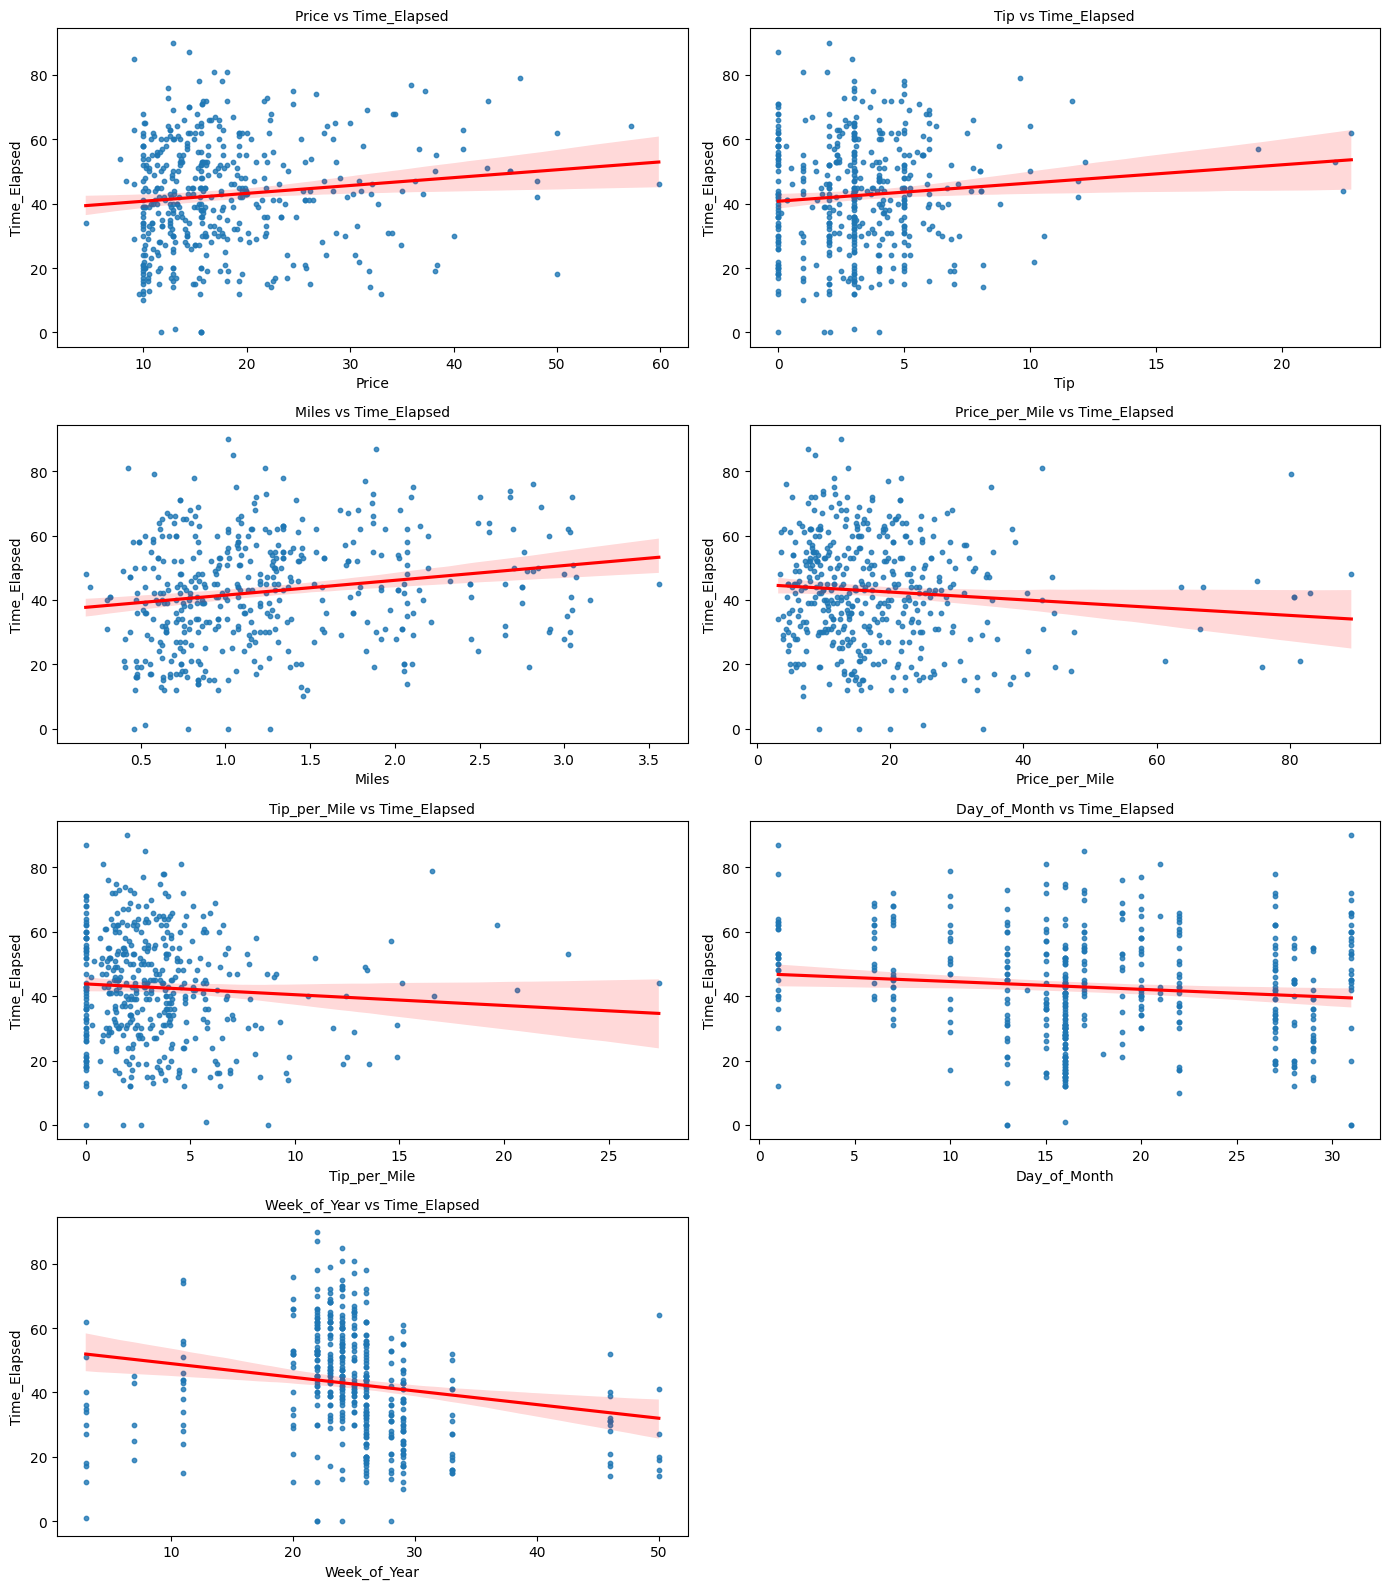

In [112]:
# Define the numerical columns
numerical_cols = ['Price','Tip','Miles','Price_per_Mile','Tip_per_Mile', 'Day_of_Month','Week_of_Year','Time_Elapsed']

num_plots = len(numerical_cols[:-1])
n_cols = 2
n_rows = (num_plots + 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, n_rows * 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
axes = axes.flatten()

# Plot each numerical column against 'Time_Elapsed'
for i, col in enumerate(numerical_cols[:-1]):
    sns.regplot(data=data, x=col, y='Time_Elapsed', ax=axes[i], scatter_kws={"s": 10}, line_kws={"color": "red"})
    axes[i].set_title(f'{col} vs Time_Elapsed', fontsize=10)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Time_Elapsed')

for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- There is a slight positive correlation between Price and Time_Elapsed. As the price of an order increases, the time elapsed for delivery also tends to increase slightly.
- There is a noticeable positive correlation between Miles and Time_Elapsed. As the distance of delivery increases, the time elapsed for delivery also tends to increase. This relationship is more pronounced suggesting that distance is a more significant factor in determining delivery time.
- There is a very slight negative correlation between Day_of_Month and Time_Elapsed, meaning that deliveries tend to be slightly faster as the month progresses.
- There is a slight negative correlation between the Week_of_Year and Time_Elapsed, meaning that as the weeks progress throughout the year, the delivery time tends to decrease slightly

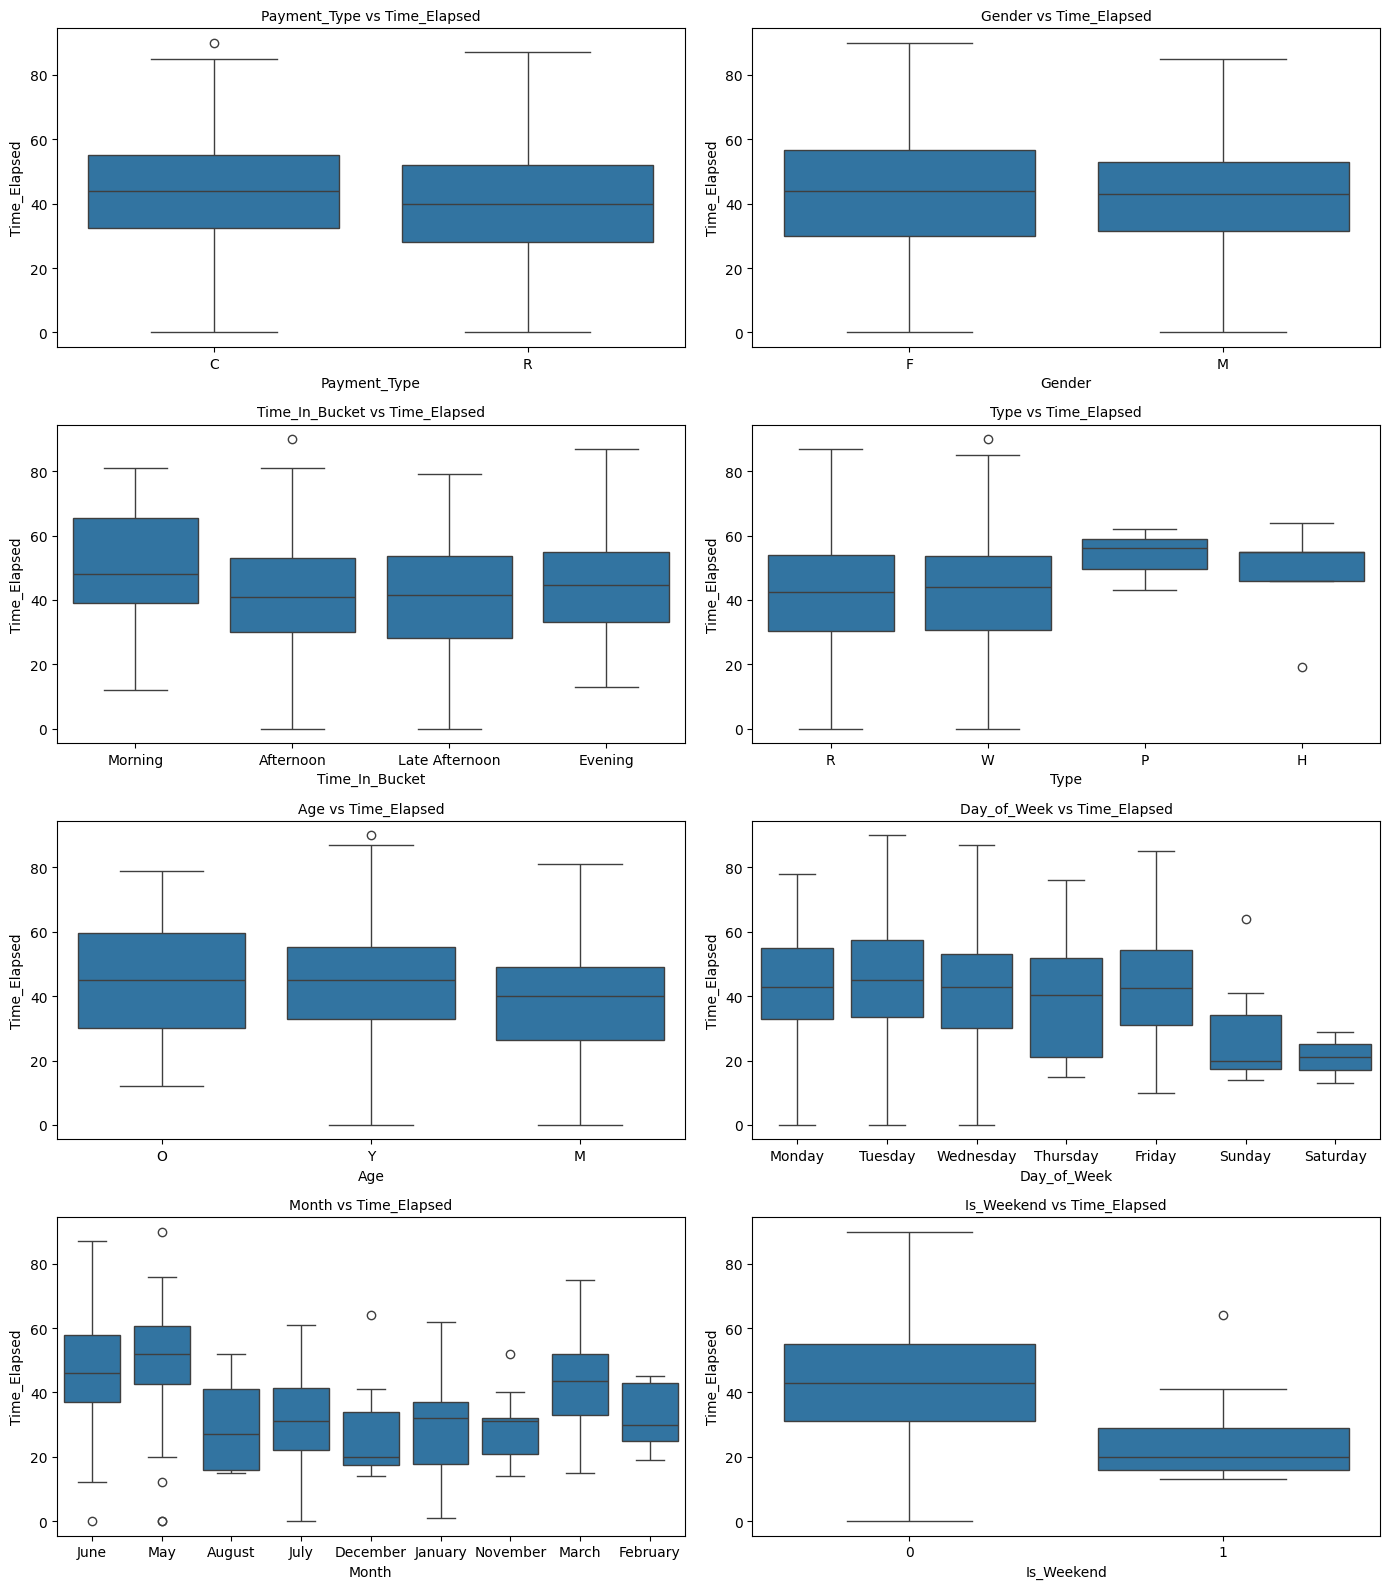

In [113]:
categorical_cols = ['Payment_Type', 'Gender', 'Time_In_Bucket', 'Type', 'Age','Day_of_Week','Month','Is_Weekend']

num_plots = len(categorical_cols)
n_cols = 2
n_rows = (num_plots + 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, n_rows * 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
axes = axes.flatten()

# Plot each categorical column against 'Time_Elapsed'
for i, col in enumerate(categorical_cols):
    sns.boxplot(data=data, x=col, y='Time_Elapsed', ax=axes[i])
    axes[i].set_title(f'{col} vs Time_Elapsed', fontsize=10)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Time_Elapsed')

# Remove any unused subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- There is no significant difference in Time_Elapsed between cash ('C') and credit ('R') payments. Both have a similar median of around 40-43 minutes time taken to deliver an order and interquartile range.
- The delivery time (Time_Elapsed) is quite similar for both female ('F') and male ('M') customers, with overlapping interquartile ranges and medians.
- Deliveries in the morning tend to have a higher median Time_Elapsed compared to other times of the day suggesting that morning deliveries may take slightly longer. Afternoon, late afternoon, and evening deliveries have similar median delivery times, but evening deliveries show slightly more variability.
- Orders from residences ('R') and work locations ('W') have similar median delivery times, but work locations show more variability.
- The delivery time is relatively consistent across different age groups (Old 'O', Young 'Y', and Middle 'M'), with overlapping medians and interquartile ranges.
- Delivery times tend to be faster on weekends, particularly on Saturday with a median order delivery time almost lower than 20 minutes. Weekdays show similar delivery times with more variability.
- There is some seasonal variation in delivery times. Mid-year months (May and June) tend to have longer delivery times, while end-of-year or beginning-of-year months (November, December, January and February) have shorter delivery times.
- Both Tip_per_Mile and Price_per_Mile show slight negative correlations with Time_Elapsed, indicating that higher tips and prices per mile might lead to shorter delivery times. However, these relationships are weak and show considerable variability.
- The Is_Weekend feature indicates that weekends generally have shorter delivery times compared to weekdays. This could be a useful feature in the predictive model.

So we can drop the features that seem to not have any significant impact on Time_Elapsed such as Gender, Type, Payment_Type.
We can also drop Day_of_Wee as we have Is_Weekend indicator which captures the relationship of weekday and weekend that we see on Day_of_Week


In [174]:
data = data.drop(['Gender','Type','Payment_Type','Day_of_Week'],axis=1)

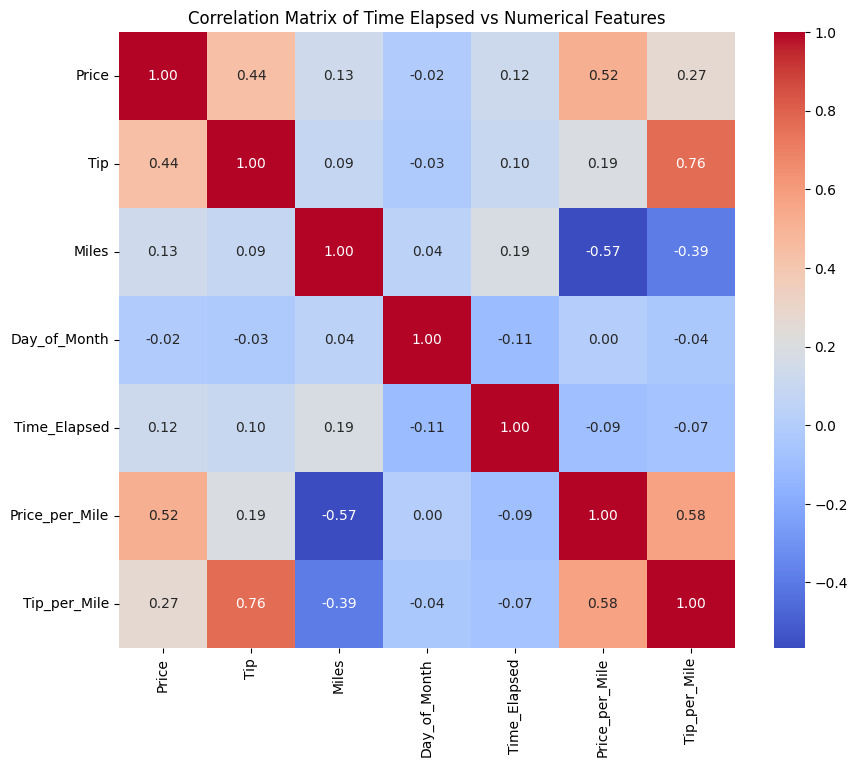

In [119]:
def correlation(df):
    """
    Plots correlation matrix.

    """
    plt.figure(figsize=(10, 8))
    corr = df.corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
    plt.title('Correlation Matrix of Time Elapsed vs Numerical Features')
    plt.show()

correlation(data[['Price','Tip','Miles', 'Day_of_Month','Time_Elapsed','Price_per_Mile','Tip_per_Mile']])

- Price: There is a weak positive correlation (0.12) with Time_Elapsed. This suggests that higher prices are slightly associated with longer delivery times, but the relationship is weak.

- Tip: There is a very weak positive correlation (0.10) with Time_Elapsed. This indicates that higher tips are slightly associated with longer delivery times, though the correlation is minimal.

- Miles: There is a moderate positive correlation (0.19) with Time_Elapsed. This suggests that longer delivery distances (more miles) are somewhat associated with longer delivery times.

- Day_of_Month: There is a weak negative correlation (-0.11) with Time_Elapsed. This suggests that as the days in the month progress, the delivery times tend to decrease slightly.

In [175]:
def calculate_predictive_power(df, target):
    """
    Calculates the predictive power score (PPS) for variables in a dataframe against a target variable.
    
    """
    predictors_df = pps.predictors(df, target)
    sorted_predictors = predictors_df.sort_values(by="ppscore", ascending=False)
    
    return sorted_predictors

predictors_df = calculate_predictive_power(data, "Time_Elapsed")
predictors_df

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,Week_of_Year,Time_Elapsed,0.116230,regression,True,mean absolute error,13.682713,12.092375,DecisionTreeRegressor()
1,Month,Time_Elapsed,0.091247,regression,True,mean absolute error,13.682713,12.434209,DecisionTreeRegressor()
2,Day_of_Month,Time_Elapsed,0.079967,regression,True,mean absolute error,13.682713,12.588547,DecisionTreeRegressor()
3,Age,Time_Elapsed,0.007983,regression,True,mean absolute error,13.682713,13.573490,DecisionTreeRegressor()
4,Is_Weekend,Time_Elapsed,0.005950,regression,True,mean absolute error,13.682713,13.601306,DecisionTreeRegressor()
5,Tip,Time_Elapsed,0.000000,regression,True,mean absolute error,13.682713,15.522273,DecisionTreeRegressor()
6,Price,Time_Elapsed,0.000000,regression,True,mean absolute error,13.682713,17.648038,DecisionTreeRegressor()
7,Miles,Time_Elapsed,0.000000,regression,True,mean absolute error,13.682713,16.891633,DecisionTreeRegressor()
8,Time_In_Bucket,Time_Elapsed,0.000000,regression,True,mean absolute error,13.682713,13.775246,DecisionTreeRegressor()
9,Price_per_Mile,Time_Elapsed,0.000000,regression,True,mean absolute error,13.682713,17.809786,DecisionTreeRegressor()


### Feature Selection

- The Month, Day_of_Month and Week_of_Year of are the only features with some predictive power, though still relatively low.
- Most features (Age, Payment_Type, Gender, Tip, Type, Price, Miles, Time_In_Bucket, and Day_of_Week) do not significantly contribute to predicting Time_Elapsed.

The results suggest that other features or more sophisticated models may be needed to for predictions of Time_Elapsed. We will use these features to build the model and evaluate from there.

## 3. Modelling

- Before building the model we need to do one-hot encoding for categorical variables, basically transforming text data to numbers, as machine learning modesls understand numbers.
- We can use a Linear regression to build a predictive model but this model assumes that features are normally distribited so we'd need to transform the numerical features to be normal or we can use Tree-based models such as Random forest which are not sensitive to skewed data.


In [134]:
# def label_encode_columns(df, columns):
#     """
#     Performs label encoding on specified columns in a DataFrame.

#     """
#     label_encoders = {}
#     for column in columns:
#         label_encoder = LabelEncoder()
#         df[column] = label_encoder.fit_transform(df[column])
#         label_encoders[column] = label_encoder
#     return df, label_encoders

# columns_to_encode = ['Month', 'Age', 'Time_In_Bucket']
# data_encoded, encoders = label_encode_columns(data, columns_to_encode)
# data_encoded.head()


,Tip,Price,Age,Time_Elapsed,Miles,Time_In_Bucket,Day_of_Month,Month,Week_of_Year,Is_Weekend,Price_per_Mile,Tip_per_Mile
2,2.62,12.38,1,73.0,1.240314,3,13,5,24,0,9.981340,2.112368
3,2.00,16.02,2,52.0,1.775961,3,31,7,22,0,9.020467,1.126151
4,1.93,18.07,0,81.0,0.422552,3,15,5,24,0,42.763968,4.567485
5,3.75,37.25,0,75.0,1.061973,3,15,5,24,0,35.076235,3.531165
6,2.30,29.72,2,42.0,0.733873,3,13,5,24,0,40.497448,3.134056


In [177]:
def one_hot_encode_columns(df, columns):
    """
    Performs one-hot encoding on specified columns in a DataFrame.
    
    """
    df_encoded = pd.get_dummies(df, columns=columns, drop_first=True)
    df_encoded = df_encoded.astype(int) 
    return df_encoded

columns_to_encode = ['Month', 'Age', 'Time_In_Bucket']
data_encoded = one_hot_encode_columns(data, columns_to_encode)
data_encoded.head()

,Tip,Price,Time_Elapsed,Miles,Day_of_Month,Week_of_Year,Is_Weekend,Price_per_Mile,Tip_per_Mile,Month_December,...,Month_July,Month_June,Month_March,Month_May,Month_November,Age_O,Age_Y,Time_In_Bucket_Evening,Time_In_Bucket_Late Afternoon,Time_In_Bucket_Morning
2,2,12,73,1,13,24,0,9,2,0,...,0,1,0,0,0,1,0,0,0,1
3,2,16,52,1,31,22,0,9,1,0,...,0,0,0,1,0,0,1,0,0,1
4,1,18,81,0,15,24,0,42,4,0,...,0,1,0,0,0,0,0,0,0,1
5,3,37,75,1,15,24,0,35,3,0,...,0,1,0,0,0,0,0,0,0,1
6,2,29,42,0,13,24,0,40,3,0,...,0,1,0,0,0,0,1,0,0,1


In [183]:
def log_transform_columns(df, columns):
    """
    Performs log transformation on specified columns in a DataFrame.

    """
    for column in columns:
        df[column] = np.log1p(df[column])
    return df

# Log transform numerical columns
columns_to_transform = ['Price', 'Miles', 'Price_per_Mile', 'Tip_per_Mile', 'Tip']
data_transformed = log_transform_columns(data_encoded, columns_to_transform)
data_transformed.head()

,Tip,Price,Time_Elapsed,Miles,Day_of_Month,Week_of_Year,Is_Weekend,Price_per_Mile,Tip_per_Mile,Month_December,...,Month_July,Month_June,Month_March,Month_May,Month_November,Age_O,Age_Y,Time_In_Bucket_Evening,Time_In_Bucket_Late Afternoon,Time_In_Bucket_Morning
2,1.098612,2.564949,73,0.693147,13,24,0,2.302585,1.098612,0,...,0,1,0,0,0,1,0,0,0,1
3,1.098612,2.833213,52,0.693147,31,22,0,2.302585,0.693147,0,...,0,0,0,1,0,0,1,0,0,1
4,0.693147,2.944439,81,0.000000,15,24,0,3.761200,1.609438,0,...,0,1,0,0,0,0,0,0,0,1
5,1.386294,3.637586,75,0.693147,15,24,0,3.583519,1.386294,0,...,0,1,0,0,0,0,0,0,0,1
6,1.098612,3.401197,42,0.000000,13,24,0,3.713572,1.386294,0,...,0,1,0,0,0,0,1,0,0,1


In [184]:
def set_features_and_target(df):
    '''
    Returns two data frames with features and target variables.
            Parameters:
                    df (str): Pandas dataframe
    '''
    X = df.drop(['Time_Elapsed'], axis=1)
    y = df['Time_Elapsed']
    
    return X,y
                 
X,y = set_features_and_target(data_transformed)
print(X.shape, y.shape)

(457, 21) (457,)


In [185]:
def train_test_split_df(X,y):
    '''
    Creates train and test split.

    '''
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split_df(X,y)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(274, 21) (274,)
(183, 21) (183,)


In [186]:
def model_application(X_train, y_train, optimiser):
    '''
    Model application. If optimiser is true, a grid search is applied to optimise the model. 
    If optimiser is false, the base model is used.

    '''
    if optimiser:
        # Define the parameters for grid search
        params = {
            'max_features': [1, 3, 10, 0.5],
            'min_samples_split': [2, 3, 10],
            'min_samples_leaf': [1, 3, 10],
            'criterion': ["squared_error", "absolute_error"]
        }

        # Using K-fold cross-validation
        cv = KFold(n_splits=5, shuffle=True, random_state=15)

        # Building the model
        rf = RandomForestRegressor()

        # Parameter estimation using GridSearch
        grid = GridSearchCV(rf, param_grid=params, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, verbose=1)
        
        # Fitting the model
        grid.fit(X_train, y_train)

        best_score = grid.best_score_
        print('Best Score:', best_score)
        print('Best Params:', grid.best_params_)
        print('Best Estimator:', grid.best_estimator_)

        rf_reg = grid.best_estimator_
    else:
        rf_reg = RandomForestRegressor(n_estimators=150,
                                       max_depth=16,
                                       criterion='squared_error',
                                       min_samples_split=10,
                                       max_leaf_nodes=20,
                                       max_features=0.5,
                                       bootstrap=True)
        rf_reg.fit(X_train, y_train)

    return rf_reg

optimiser = True
rf_reg = model_application(X_train, y_train, optimiser)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Score: -11.746977441077442
Best Params: {'criterion': 'absolute_error', 'max_features': 0.5, 'min_samples_leaf': 3, 'min_samples_split': 3}
Best Estimator: RandomForestRegressor(criterion='absolute_error', max_features=0.5,
                      min_samples_leaf=3, min_samples_split=3)


In [187]:
def model_predict(rf, X_test):
    """
    Create y_pred, model prediction based on test set features.

    """
    y_pred = rf.predict(X_test)
    return y_pred

y_pred = model_predict(rf_reg, X_test)

# Print R-squared for training and test sets
print('Training R-squared Score (%):', rf_reg.score(X_train, y_train) * 100)
print('Test R-squared Score (%):', rf_reg.score(X_test, y_test) * 100)

# Print other regression metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)

Training R-squared Score (%): 53.693005718979414
Test R-squared Score (%): 23.623448788702273
Mean Squared Error: 221.82538333333335
Root Mean Squared Error: 14.89380352137537


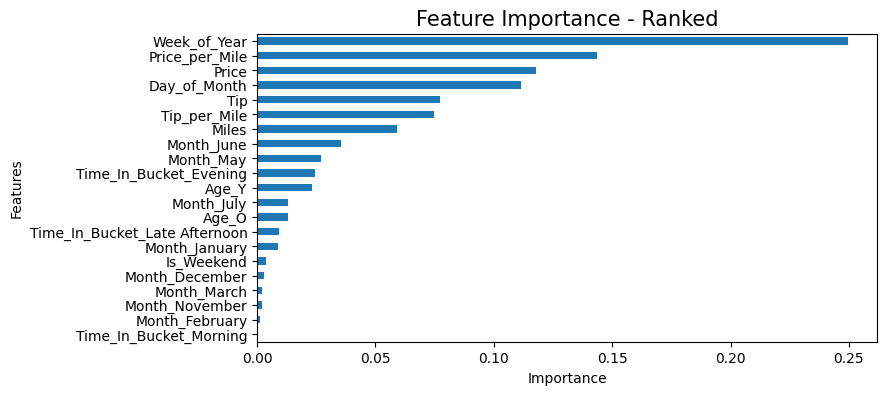

In [188]:
def plot_feature_importance(model, feature_names, n=30):
    
    '''
    Produces a plot displaying features that are most important predictors of the target feature.
            Parameters:
                    random forest model
                    feature names
    '''
    
    plt.figure(figsize=(8, 4))

    feat_importances = pd.Series(model.feature_importances_, index=feature_names)
    feat_importances.nsmallest(n).plot(kind='barh')
    importances = model.feature_importances_
    indices = np.argsort(importances)

    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title("Feature Importance - Ranked", fontsize=15)
    plt.show()

plot_feature_importance(rf_reg, X_train.columns)